In [1]:
%load_ext autoreload
%autoreload

import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from equationmodel_gp import gp_regression, prediction_rmse_error, gp_train_graph, gp_linear_compare_graph
from equationmodel_ann import ann_mlp_regression, prediction_rmse_error, ann_linear_compare_graph
from util import ADD_data_loader, combineDF, filteringDF, getFreeSpacePathLoss, makeXforGraphWithGroupingFrequency,\
                makeXforGraph, inverseScale, samplingData, normalizeData,train_2d_graph, train_3d_graph,\
                makeXforGraphWithGroupingSeason, train_2d_sigma_graph, train_2d_sigma_graph_s, groupWithFrequency

desired_width=620
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns',30)
pd.options.display.float_format = "{:.2f}".format

In [2]:
%autoreload

wt_fileList = {'../data/PLdata_paju_wt_400.csv':[('season', 0.1), ('frequency', 400), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_1399.csv':[('season', 0.1), ('frequency', 1399), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_2249.csv':[('season', 0.1), ('frequency', 2249), ('heightTB',100), ('heightB',7), ('heightM',2)]}
sp_fileList = {'../data/PLdata_paju_sp_400.csv':[('season', 0.7), ('frequency', 400), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_sp_1399.csv':[('season', 0.7), ('frequency', 1399), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_sp_2249.csv':[('season', 0.7), ('frequency', 2249), ('heightTB',100), ('heightB',7), ('heightM',2)]}
sm_fileList = {'../data/PLdata_paju_sm_400.csv':[('season', 1.0), ('frequency', 400), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_sm_1399.csv':[('season', 1.0), ('frequency', 1399), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_sm_2249.csv':[('season', 1.0), ('frequency', 2249), ('heightTB',100), ('heightB',7), ('heightM',2)]}

addWt = ADD_data_loader(wt_fileList)
print("winter data:",addWt.shape)
print("")
addSp = ADD_data_loader(sp_fileList)
print("spring data:",addSp.shape)
print("")
addSm = ADD_data_loader(sm_fileList)
print("summer data:",addSm.shape)
print("")

print("addWt")
print("antenna_b height filtering-before(data count):",addWt.shape)
addWt = filteringDF(addWt, 'heightTM', [10,100])
print("antenna_b height filtering-after(data count):",addWt.shape)

print("freespace pathloss filtering-before(data count):",addWt.shape)
addWt['freePathloss'] = getFreeSpacePathLoss(addWt['distance'],addWt['frequency'])
addWt = addWt[addWt['pathloss'] >= addWt['freePathloss']]
print("freespace pathloss filtering-after(data count):",addWt.shape)
#-------------------------------------------------------------------------------------------------
print("addSp")
print("antenna_b height filtering-before(data count):",addSp.shape)
addSp = filteringDF(addSp, 'heightTM', [10,100])
print("antenna_b height filtering-after(data count):",addSp.shape)

print("freespace pathloss filtering-before(data count):",addSp.shape)
addSp['freePathloss'] = getFreeSpacePathLoss(addSp['distance'],addSp['frequency'])
addSp = addSp[addSp['pathloss'] >= addSp['freePathloss']]
print("freespace pathloss filtering-after(data count):",addSp.shape)
#-------------------------------------------------------------------------------------------------
print("addIksanSm")
print("antenna_b height filtering-before(data count):",addSm.shape)
addSm = filteringDF(addSm, 'heightTM', [10,100])
print("antenna_b height filtering-after(data count):",addSm.shape)

print("freespace pathloss filtering-before(data count):",addSm.shape)
addSm['freePathloss'] = getFreeSpacePathLoss(addSm['distance'],addSm['frequency'])
addSm = addSm[addSm['pathloss'] >= addSm['freePathloss']]
print("freespace pathloss filtering-after(data count):",addSm.shape)

# print("ADD data sample:\n",addData.head())

ADD data preprocessing
../data/PLdata_paju_wt_400.csv: distance filtering(before):(110440, 4)
../data/PLdata_paju_wt_400.csv: distance filtering(after):(21356, 4)
../data/PLdata_paju_wt_1399.csv: distance filtering(before):(110358, 4)
../data/PLdata_paju_wt_1399.csv: distance filtering(after):(21342, 4)
../data/PLdata_paju_wt_2249.csv: distance filtering(before):(110246, 4)
../data/PLdata_paju_wt_2249.csv: distance filtering(after):(21324, 4)
          type  distance  pathloss  heightTM  season  frequency  heightTB  heightB  heightM
type 2895    m      1.26    103.32      0.02    0.10        400       100        7        2
     2896    m      1.26     98.76      0.01    0.10        400       100        7        2
     2897    m      1.26    106.93      0.01    0.10        400       100        7        2
     2898    m      1.26    114.74      0.00    0.10        400       100        7        2
     2899    m      1.26    118.19      0.02    0.10        400       100        7        2
C

In [3]:
%autoreload

targetCols = ['logDistance', 'pathloss']
xCols = ['logDistance']
yCols = ['pathloss']

samplingRatio = 0.1
print(addWt.describe())
print(addSp.describe())
print(addSm.describe())

# addDataSample.sort_values(by=['logDistance'])
addWtSampled = samplingData(addWt[targetCols], samplingRatio, None)
addSpSampled = samplingData(addSp[targetCols], samplingRatio, None)
addSmSampled = samplingData(addSm[targetCols], samplingRatio, None)

stdDist = {0.1:list(), 0.7:list(), 1.0:list()}

       distance  pathloss  heightTM   season  frequency  heightTB  heightB  heightM  freePathloss  logDistance  heightTratio  extendedHeightTratio  logFrequency  logHeightB  logHeightTM  logHeightTratio  logExtendedHeightTratio  logAntennaMulLogDistance  combinedDistance
count  42357.00  42357.00  42357.00 42357.00   42357.00  42357.00 42357.00 42357.00      42357.00     42357.00      42357.00              42357.00      42357.00    42357.00     42357.00         42357.00                 42357.00                  42357.00          42357.00
mean       2.67    125.29     24.77     0.10    1350.73    100.00     7.00     2.00        101.27         0.41          0.25                  0.25          3.03        0.85         1.35            -0.65                     0.64                      0.34              0.75
std        0.78     14.09     12.34     0.00     754.18      0.00     0.00     0.00          6.87         0.14          0.12                  0.12          0.32        0.00         0.1


Objective Function
L_pathloss =  14.31log_d + 119.50
minmaxSTD: (3.164978333059786, 3.6550299893881366)
meanSTD: 3.1917792946898578
Train STD minmax: 3.1917792946898578


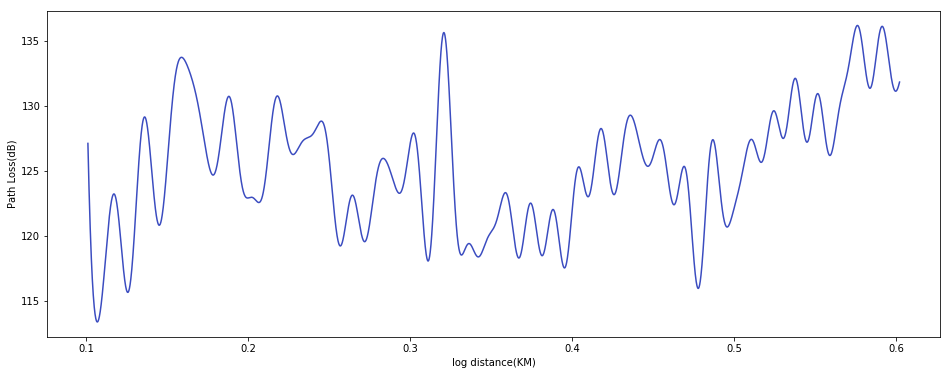

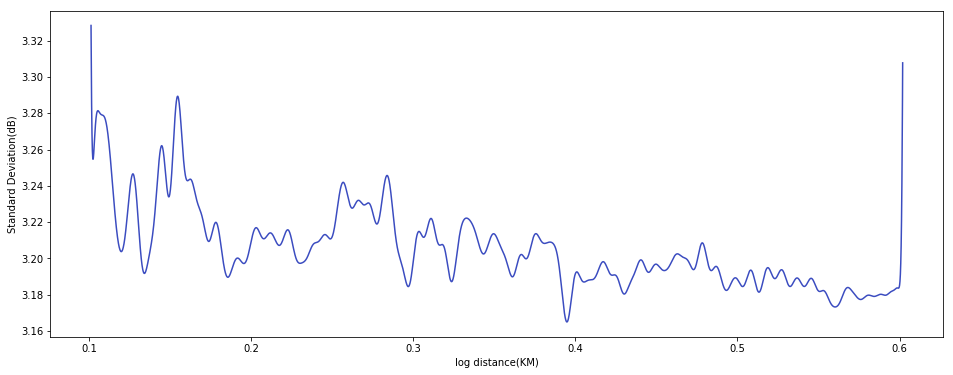

{0.1: [3.1917792946898578], 0.7: [], 1.0: []}


In [4]:
%autoreload

X = np.array(addWtSampled[xCols])
Y = np.array(addWtSampled[yCols])

modelList = []
dataSet = []
i = 1

stdTrainSum, stdTestSum = 0, 0
kernel = 'RBF'

model = gp_regression(kernel)
model.fit(X, Y)

pred, std = model.predict(X, return_std=True)
linearModel = Ridge(alpha=0.00)
linearModel.fit(X, pred)
print("\nObjective Function")
print("L_pathloss = {:6.2f}log_d + {:6.2f}".format(linearModel.coef_[0],linearModel.intercept_))

minmaxSTD = stats.describe(std).minmax
meanSTD = stats.describe(std).mean
print("minmaxSTD:",minmaxSTD)
print("meanSTD:",meanSTD)
print("Train STD minmax: {}".format(meanSTD))
stdDist[0.1].append(meanSTD)

train_2d_sigma_graph_s(model, X, Y, targetCol = 'logDistance', sigmaFlag = False)   
train_2d_sigma_graph_s(model, X, Y, targetCol = 'logDistance', sigmaFlag = True)  

print(stdDist)


Objective Function
L_pathloss =  26.73log_d + 118.45
minmaxSTD: (3.1777029428793786, 4.089346529068356)
meanSTD: 3.2151345047118762
Train STD minmax: 3.2151345047118762


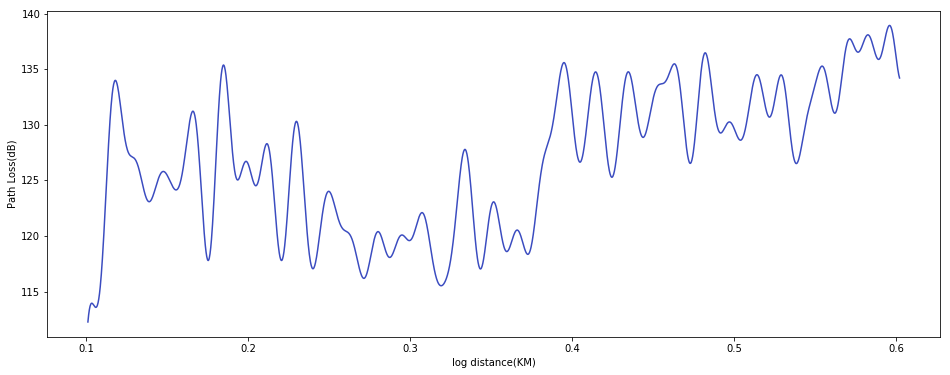

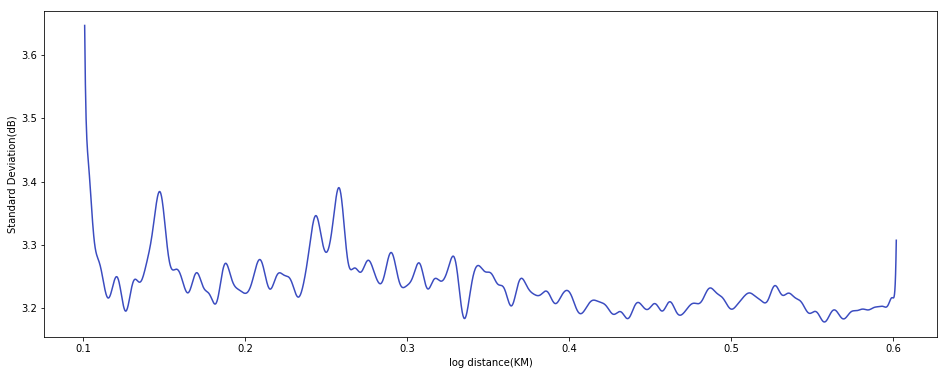

{0.1: [3.1917792946898578], 0.7: [3.2151345047118762], 1.0: []}


In [5]:
%autoreload

X = np.array(addSpSampled[xCols])
Y = np.array(addSpSampled[yCols])

modelList = []
dataSet = []
i = 1

stdTrainSum, stdTestSum = 0, 0
kernel = 'RBF'

model = gp_regression(kernel)
model.fit(X, Y)

pred, std = model.predict(X, return_std=True)
linearModel = Ridge(alpha=0.00)
linearModel.fit(X, pred)
print("\nObjective Function")
print("L_pathloss = {:6.2f}log_d + {:6.2f}".format(linearModel.coef_[0],linearModel.intercept_))

minmaxSTD = stats.describe(std).minmax
meanSTD = stats.describe(std).mean
print("minmaxSTD:",minmaxSTD)
print("meanSTD:",meanSTD)
print("Train STD minmax: {}".format(meanSTD))
stdDist[0.7].append(meanSTD)

train_2d_sigma_graph_s(model, X, Y, targetCol = 'logDistance', sigmaFlag = False)   
train_2d_sigma_graph_s(model, X, Y, targetCol = 'logDistance', sigmaFlag = True)  

print(stdDist)


Objective Function
L_pathloss =  14.89log_d + 123.98
minmaxSTD: (3.1714093586193974, 3.6920816851046787)
meanSTD: 3.1889249221440146
Train STD minmax: 3.1889249221440146


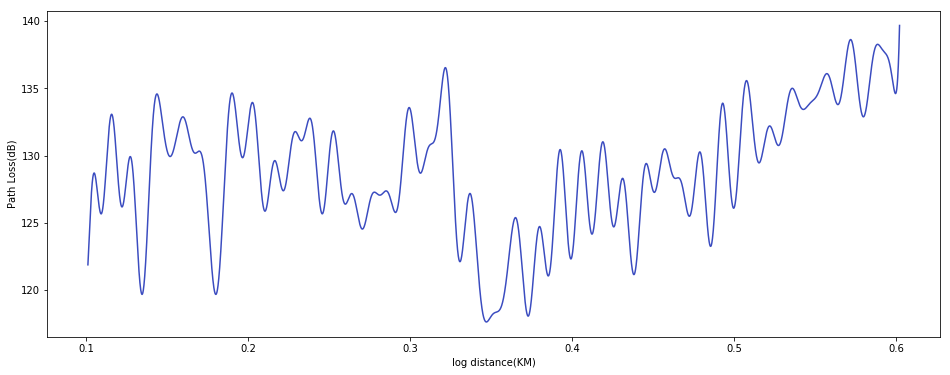

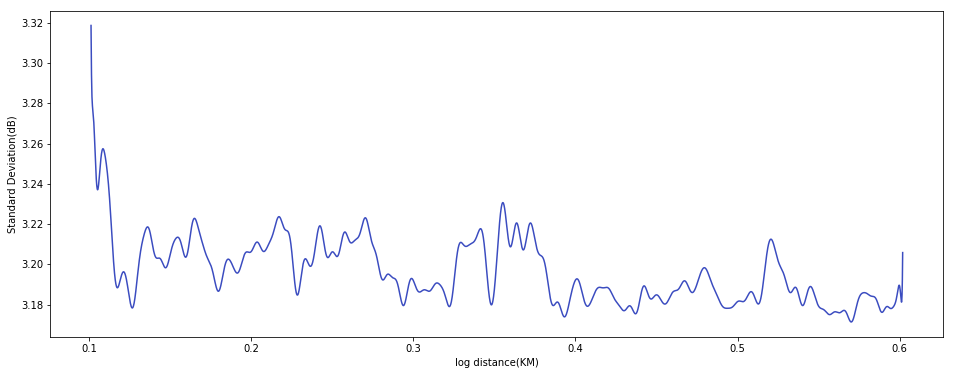

{0.1: [3.1917792946898578], 0.7: [3.2151345047118762], 1.0: [3.1889249221440146]}


In [6]:
#### %autoreload

X = np.array(addSmSampled[xCols])
Y = np.array(addSmSampled[yCols])

modelList = []
dataSet = []
i = 1

stdTrainSum, stdTestSum = 0, 0
kernel = 'RBF'

model = gp_regression(kernel)
model.fit(X, Y)

pred, std = model.predict(X, return_std=True)
linearModel = Ridge(alpha=0.00)
linearModel.fit(X, pred)
print("\nObjective Function")
print("L_pathloss = {:6.2f}log_d + {:6.2f}".format(linearModel.coef_[0],linearModel.intercept_))

minmaxSTD = stats.describe(std).minmax
meanSTD = stats.describe(std).mean
print("minmaxSTD:",minmaxSTD)
print("meanSTD:",meanSTD)
print("Train STD minmax: {}".format(meanSTD))
stdDist[1.0].append(meanSTD)

train_2d_sigma_graph_s(model, X, Y, targetCol = 'logDistance', sigmaFlag = False)   
train_2d_sigma_graph_s(model, X, Y, targetCol = 'logDistance', sigmaFlag = True)  

print(stdDist)

In [8]:
print(stdDist)
STD = list()
for k,v in stdDist.items():
    for val in v:
        STD.append([k,val])
print(STD)
STDarray = np.array(STD)
X = STDarray[:,0]
Y = STDarray[:,1]
linearModel = Ridge(alpha=0.0)
linearModel.fit(X.reshape(-1,1), Y.reshape(-1,1))

print("\nObjective Function")
print("STD = {}s + {:6.2f}".format(linearModel.coef_[0],linearModel.intercept_)) 

{0.1: [3.1917792946898578], 0.7: [3.2151345047118762], 1.0: [3.1889249221440146]}
[[0.1, 3.1917792946898578], [0.7, 3.2151345047118762], [1.0, 3.1889249221440146]]

Objective Function
STD = 0.0028423142472985812s +   3.20
